In [7]:
import boto3
from IPython.display import HTML, display, Image as IImage
from PIL import Image, ImageDraw, ImageFont
import time
import os

In [8]:
import sagemaker
import boto3

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

In [14]:
!aws s3 cp --recursive ./faces/ s3://$bucket/content-moderation/media/

upload: faces/sad/sad_1.jpg to s3://sagemaker-us-east-1-211125778552/content-moderation/media/sad/sad_1.jpg


In [15]:
rekognition = boto3.client("rekognition")
s3 = boto3.client("s3")

/home/sagemaker-user/.conda/envs/data_science_on_aws/lib/python3.7/site-packages/boto3/compat.py:82: PythonDeprecationWarning: Boto3 will no longer support Python 3.7 starting December 13, 2023. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.8 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [16]:
!mkdir -p ./tmp
temp_folder = "tmp/"

In [21]:
imageName = "content-moderation/media/sad/sad_1.jpg"

In [22]:
display(IImage(url=s3.generate_presigned_url("get_object", Params={"Bucket": bucket, "Key": imageName})))

In [27]:
detectFaceResponse = rekognition.detect_faces(
    Image={
        "S3Object": {
            "Bucket": bucket,
            "Name": imageName,
        }
    },
    Attributes=['ALL']
)


In [28]:
display(detectFaceResponse)

{'FaceDetails': [{'BoundingBox': {'Width': 0.643302857875824,
    'Height': 0.8167975544929504,
    'Left': 0.17561419308185577,
    'Top': 0.0939672663807869},
   'AgeRange': {'Low': 35, 'High': 43},
   'Smile': {'Value': False, 'Confidence': 94.67340087890625},
   'Eyeglasses': {'Value': False, 'Confidence': 99.99946594238281},
   'Sunglasses': {'Value': False, 'Confidence': 99.9998779296875},
   'Gender': {'Value': 'Female', 'Confidence': 99.99998474121094},
   'Beard': {'Value': False, 'Confidence': 99.9998779296875},
   'Mustache': {'Value': False, 'Confidence': 100.0},
   'EyesOpen': {'Value': True, 'Confidence': 96.93415832519531},
   'MouthOpen': {'Value': False, 'Confidence': 79.94832611083984},
   'Emotions': [{'Type': 'CALM', 'Confidence': 94.140625},
    {'Type': 'CONFUSED', 'Confidence': 1.98822021484375},
    {'Type': 'HAPPY', 'Confidence': 0.2744038701057434},
    {'Type': 'SURPRISED', 'Confidence': 0.21946430206298828},
    {'Type': 'ANGRY', 'Confidence': 0.050020217895

In [29]:
def drawBoundingBoxes(sourceImage, boxes):
    # blue, green, red, grey
    colors = ((255, 255, 255), (255, 255, 255), (76, 182, 252), (52, 194, 123))

    # Download image locally
    imageLocation = temp_folder + os.path.basename(sourceImage)
    s3.download_file(bucket, sourceImage, imageLocation)

    # Draws BB on Image
    bbImage = Image.open(imageLocation)
    draw = ImageDraw.Draw(bbImage)
    width, height = bbImage.size
    col = 0
    maxcol = len(colors)
    line = 3
    for box in boxes:
        x1 = int(box[1]["Left"] * width)
        y1 = int(box[1]["Top"] * height)
        x2 = int(box[1]["Left"] * width + box[1]["Width"] * width)
        y2 = int(box[1]["Top"] * height + box[1]["Height"] * height)

        draw.text((x1, y1), box[0], colors[col])
        for l in range(line):
            draw.rectangle((x1 - l, y1 - l, x2 + l, y2 + l), outline=colors[col])
        col = (col + 1) % maxcol

    imageFormat = "PNG"
    ext = sourceImage.lower()
    if ext.endswith("jpg") or ext.endswith("jpeg"):
        imageFormat = "JPEG"

    bbImage.save(imageLocation, format=imageFormat)

    display(bbImage)

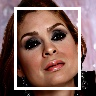

In [45]:
boxes = []
response = detectFaceResponse['FaceDetails']
for faceDetection in response:
    boxes.append((faceDetection['Landmarks'], faceDetection["BoundingBox"]))

drawBoundingBoxes(imageName, boxes)

In [47]:
for faceDetail in response:
    print('Emotions:\tConfidence\n')
    
    for emotion in faceDetail['Emotions']:
        print(f"{emotion['Type']}\t\t{emotion['Confidence']}")
    
    print('\n')  # Add a new line between each face's emotions

Emotions:	Confidence

CALM		94.140625
CONFUSED		1.98822021484375
HAPPY		0.2744038701057434
SURPRISED		0.21946430206298828
ANGRY		0.05002021789550781
DISGUSTED		0.015985965728759766
SAD		0.004172325134277344
FEAR		0.0005662441253662109




### Clean-up

In [48]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [49]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>